# *scikit-image* demo

Tous les modules et sous-modules utilisés dans cette démo sont chargés ici.

In [47]:
# import all modules and submodules used in this demo

import os

import numpy as np
import matplotlib.pyplot as plt
import skimage.io
import skimage.exposure
import skimage.measure
import skimage.filters

In [48]:
%matplotlib inline

### Chargement et affichage de l'image analysée

L'image analysée dans cette démo est chargée avec la fonction `imread()` du sous-module `io` de *scikit-image*. Il s'agit d'une image RGB stockée dans un fichier au format TIFF (extension `.tif`.

In [49]:
fname = os.path.join("./img", "FluorescentCells.tif")
fluocells = skimage.io.imread(fname)
print(type(fluocells))

<class 'numpy.ndarray'>


L'image est stockée dans un objet de type `numpy.ndarray`. Nous pouvons donc utiliser ses attributs (notamment `.ndim`, `.size`, `.shape`, `.min()`, `.max()`, et `.dtype`) pour obtenir quelques informations supplémentaires sur cette image.

In [50]:
print(fluocells.ndim, "dimensions")
print(fluocells.size, "elements")
print("Shape:", fluocells.shape)
print(f"Range: {fluocells.min()}..{fluocells.max()} ({fluocells.dtype})")

3 dimensions
786432 elements
Shape: (512, 512, 3)
Range: 0..255 (uint8)


L'image comporte trois dimensions. Comme vu dans l'introduction, les deux premières dimensions correspondent aux coordonnées (ligne, colonne) des pixels de l'image, alors que la troisième dimension correspond aux canaux rouge, vert, et bleu.

La valeur de chaque pixel dans un canal donné est comprise entre `0` (intensité minimale) et `255` (intensité maximale). Cette gamme de valeurs est en effet utilisée par le type de données `uint8`.

Affichons l'image à l'aide de la fonction `imshow()` du module `matplotlib.pyplot` (alias `plt`).

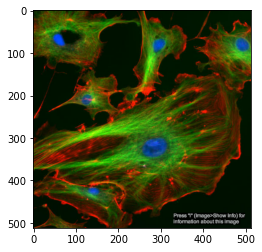

In [51]:
plt.imshow(fluocells);

D'après [ce document](https://imagej.nih.gov/ij/images/FluorescentCells.txt), il s'agit d'une image de cellules endothéliales bovines obtenue par microscopie à fluorescence. Les filaments d'actine sont marqués en rouge, les microtubules en vert, et les noyaux en bleu.

### Extraction des canaux

Commençons par extraire chaque canal de cette image en utilisant des tranches sur `fluocells`, l'*array numpy* dans lequel elle est stockée.

In [52]:
# extract red, green, and blue channels
fluocells_r = fluocells[:, :, 0] # red
fluocells_g = fluocells[:, :, 1] # green
fluocells_b = fluocells[:, :, 2] # blue

print("fluocells_r shape:", fluocells_r.shape)
print("fluocells_g shape:", fluocells_g.shape)
print("fluocells_b shape:", fluocells_b.shape)

fluocells_r shape: (512, 512)
fluocells_g shape: (512, 512)
fluocells_b shape: (512, 512)


On voit que les *arrays numpy* résultants de ces tranchages n'ont conservé que deux dimensions correspondant aux coordonnées (ligne, colonne) des pixels de l'image, la troisième dimension, qui précisait les canaux dans l'*array numpy* d'origine, a elle disparu.

Affichons désormais chaque canal pour voir ce qu'il contient, ainsi que l'image RGB initiale.

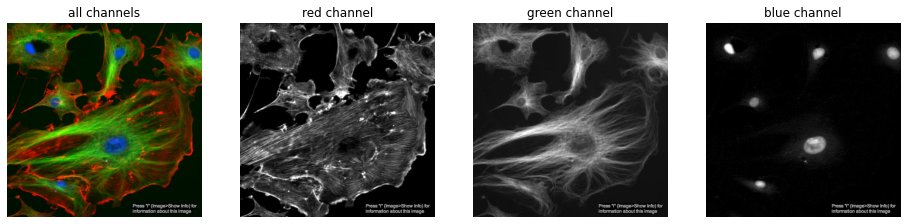

In [53]:
# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 16))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(fluocells)
axes[0].set_title("all channels")

axes[1].imshow(fluocells_r, cmap="gray")
axes[1].set_title("red channel")

axes[2].imshow(fluocells_g, cmap="gray")
axes[2].set_title("green channel")

axes[3].imshow(fluocells_b, cmap="gray")
axes[3].set_title("blue channel");

Chaque canal est ici affiché en niveaux de gris afin de les comparer plus facilement. On voit pour chaque structure une correspondance entre sa couleur dans l'image RGB (`all channels`) et l'intensité des pixels dans le canal de cette même couleur. Par exemple, les pixels des noyaux ont l'intensité la plus élevée dans le canal bleu, mais des intensités plus faibles voire quasiment nulles dans les canaux rouge et vert.

Dans la suite de cette démo, nous allons ...

## Filtrage et segmentation

Commençons par découper l'image afin de retirer le texte (situé en bas), qui risquerait autrement de nous gêner dans nos analyses. (à faire directement sur le fichier ?)

Shape: (475, 512)


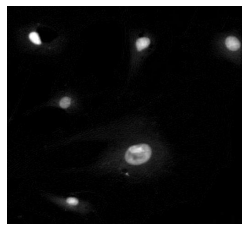

In [54]:
# remove the text; to do directly on the data file

fluocells_b = fluocells_b[:475, :]
print("Shape:", fluocells_b.shape)

plt.imshow(fluocells_b, cmap="gray")
plt.axis("Off");

### Segmentation (sans filtrage)

Nous cherchons à segmenter les noyaux présents dans cette image. Cela revient à discriminer les pixels appartenant aux noyaux des autres pixels de l'image. Etant donné que seuls les noyaux sont marqués en bleu, l'intensité dans le canal bleu des pixels appartenant aux noyaux devrait être plus élevée que celle des autre pixels. Il ne reste donc plus qu'à définir une intensité seuil au-dessus de laquelle les pixels seront considérés comme appartenant aux noyaux.

Observons d'abord la distribution des valeurs de pixels du canal bleu par un histogramme tracé avec la fonction `historgam()` du sous-module `exposure` de *scikit-image*.

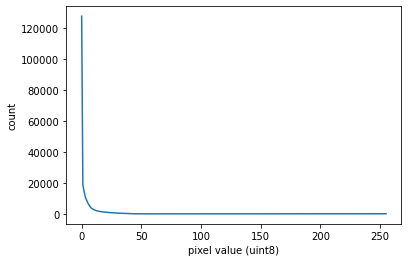

In [55]:
hist, bins = skimage.exposure.histogram(fluocells_b)
plt.plot(bins, hist)
# plt.title("fluocells_b pixel values")
plt.xlabel(f"pixel value ({fluocells_b.dtype})")
plt.ylabel("count");

La plupart des valeurs de pixel étant nulles (aucune intensité dans le canal bleu), il est impossible de ... . Nous allons donc fixer une valeur limite sur l'axe des abscisses (ici, 100).

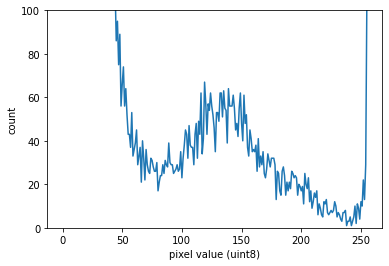

In [56]:
hist, bins = skimage.exposure.histogram(fluocells_b)
plt.plot(bins, hist)
plt.ylim(0, 100)
# plt.title("fluocells_b pixel values")
plt.xlabel(f"pixel value ({fluocells_b.dtype})")
plt.ylabel("count");

Nous apercevons un pic de valeurs qui débute à environ 80. Prenons cette valeur comme seuil afin de ne conserver que les pixels ayant une valeur supérieure au sein d'un masque booléen.

In [57]:
threshold = 80
nuclei = (fluocells_b > threshold)

# use np.unique() to get all unique values of numpy array
print(f"{nuclei.dtype}: {np.unique(nuclei)}")

# convert nuclei values to integers
nuclei = nuclei.astype(int)
print(f"{nuclei.dtype}: {np.unique(nuclei)}")

bool: [False  True]
int64: [0 1]


L'*array numpy* `nuclei` ainsi créé est en fait un masque booléen. Nous l'avons ici converti en *array numpy* d'entiers pour simplifier son utilisation avec des fonctions appelées plus loin dans la démo.

Nous affichons cet *array numpy* à côté du canal bleu.

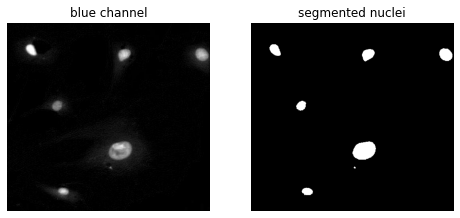

In [58]:
# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(fluocells_b, cmap="gray")
axes[0].set_title("blue channel")

axes[1].imshow(nuclei, cmap="gray")
axes[1].set_title("segmented nuclei");

Nous constatons que la segmentation a plutôt bien fonctionné : tous les noyaux ont été segmentés. Toutefois, un peit groupe de pixels n'appartenant à aucun noyau se retrouve également segmenté. Comment faire pour éviter cet artefact ? C'est là qu'intervient le filtrage de l'image.

Filtrer une image consiste à la transformer afin de lui faire subir un traitement par la suite, ici une segmentation à l'aide d'une valeur seuil. Nous cherchons ici à obtenir une image du canal bleu où les pixels incorrectement segmentés comme un noyau auraient tous une valeur inférieure au seuil de segmentation utilisé.

(Ce qui distingue ce faux noyau des noyaux authentiques est sa petite aire.)

### Filtrage

Nous allons réduire le bruit en lissant l'image par une méthode de "convolution". Cette méthode revient à calculer une nouvelle valeur pour chaque pixel en faisant la moyenne de ce pixel et des pixels l'entourant, le poids relatif de chaque pixel étant déterminé par les valeurs contenues dans un kernel. On dit qu'on effectue une convolution de l'image avec un kernel. (on dit ça ?)

In [59]:
# est-ce qu'on met l'exemple de https://scikit-image.org/skimage-tutorials/lectures/1_image_filters.html#local-filtering-of-images ?

Ici, nous utiliserons un kernel gaussien, ce qui permet de prendre en compte l'ensemble des pixels entourant le pixel recalculé d'une part, et de donner un poids à chaque pixel en fonction de sa proximité avec le pixel recalculé.

L'image filtrée `fluocells_b_filtered` est obtenue en appliquant sur le canal bleu (`fluocells_b`) la fonction `gaussian()` du sous-module `filters` de *scikit-image*.

In [60]:
fluocells_b_filtered = skimage.filters.gaussian(fluocells_b,
                                                sigma=2,
                                                preserve_range=True)

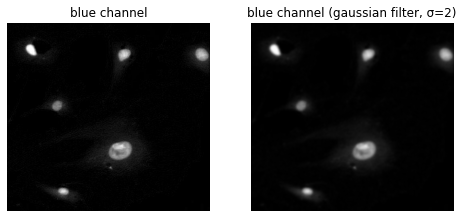

In [61]:
# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(fluocells_b, cmap="gray")
axes[0].set_title("blue channel")

axes[1].imshow(fluocells_b_filtered, cmap="gray")
axes[1].set_title("blue channel (gaussian filter, σ=2)");

Le faux noyau étant directement entouré de pixels ayant des valeurs faibles du fait de sa petite aire, on s'attend à ce que le filtrage réduise davantage son intensité que celle des noyaux authentiques, plus gros.

### Segmentation (après filtrage)

La segmentation est cette fois réalisée sur l'image filtrée.

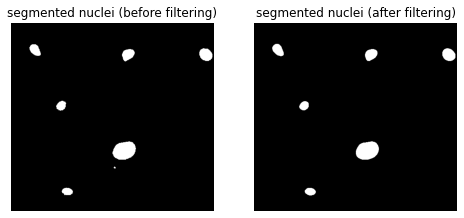

In [62]:
threshold = 80
true_nuclei = (fluocells_b_filtered > threshold)
true_nuclei = true_nuclei.astype(int)

# create subplots to display all images in a single figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 16))

# make the array of axes 1-dimensional
axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

axes[0].imshow(nuclei, cmap="gray")
axes[0].set_title("segmented nuclei (before filtering)")

axes[1].imshow(true_nuclei, cmap="gray")
axes[1].set_title("segmented nuclei (after filtering)");

Cette fois, seuls les noyaux ont été segmentés.

### Etiquetage et comptage des noyaux

La fonction `label` du sous-module `measure` de *scikit-image* permet d'étiqueter chaque région contiguë de pixels de même valeur d'un *array* d'entiers. Nous l'utilisons ici sur  pour donner un *label* à chaque noyau. En plus, elle retourne aussi le nombre de régions présentes dans l'*array numpy* avec l'argument `return_num=True`.

In [63]:
# set return_num to True to return the number of labeled regions as well
# background=0 is used to consider 0-valued pixels as background altough also a connected region
nuclei_lab, nuclei_num = skimage.measure.label(true_nuclei, background=0, return_num=True)

print("Number of nuclei:", nuclei_num)

Number of nuclei: 6


Au total, 6 régions, correspondant aux noyaux, ont été identifiées.

(475, 512)
[0 1 2 3 4 5 6]


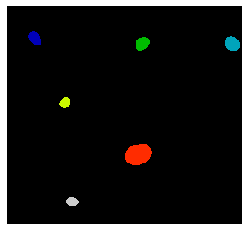

In [64]:
print(nuclei_lab.shape)
print(np.unique(nuclei_lab))
# set interpolation="none" to avoid multicolor contours around nuclei
plt.imshow(nuclei_lab, cmap="nipy_spectral", interpolation="none")
plt.axis("Off");

L'*array numpy* étiqueté (`nuclei_lab`) est de mêmes dimensions que l'*array* d'origine (`true_nuclei`), mais il comporte 7 valeurs distinctes : une valeur pour les pixels du background, et six autres valeurs (de 1 à 6) pour les 6 noyaux présents sur l'image, comme on le constate en affichant l'image étiquetée en couleurs.

## Mesures

Nous allons effectuer des mesures (aire, intensité) sur les noyaux.

Pour cela, nous commençons par créer un masque booléen pour chacun des 6 noyaux.

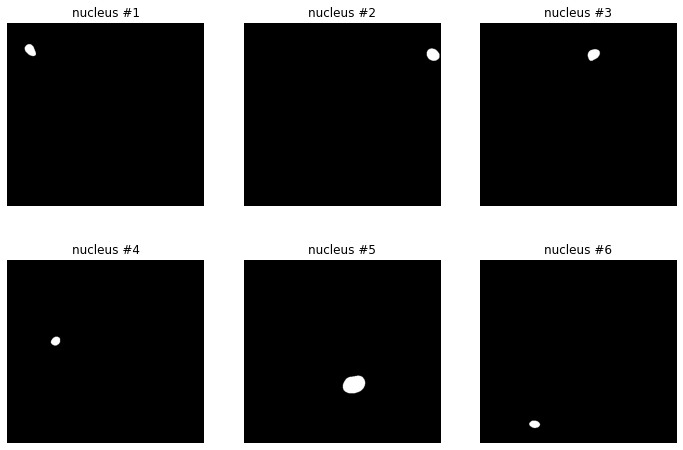

In [65]:
# list to store numpy arrays of each nucleus boolean mask
nuclei_obj = []

# create each nucleus boolean mask using its label and append it to nuclei_obj
for i in range(nuclei_num):
    nuc = (nuclei_lab == i + 1)
    nuclei_obj.append(nuc)

    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

axes = axes.ravel()

# turn off axis lines and labels
for ax in axes:
    ax.axis("off")

for i, nuc in enumerate(nuclei_obj):
    axes[i].imshow(nuc, cmap="gray")
    axes[i].set_title("nucleus #" + str(i + 1))

Les *arrays numpy* ainsi créés sont effectivement les masques booléens de chacun des 6 noyaux.

### Aire des noyaux

Pour mesurer l'aire de chaque noyau, nous comptons le nombre de pixel présent dans chaque région. Les pixels étiquetés ayant pour  valeur `True` et les autres pixels `False`, il suffit de faire la somme des éléments de chaque masque booléen pour obtenir l'aire (en pixel) de chaque noyau.

In [66]:
# measure nuclei areas

# create empty list to  store areas
nuc_areas = []

# measure each nucleus area and append it to nuc_areas
for i in range(nuclei_num):
    area = np.sum(nuclei_obj[i])
    nuc_areas.append(area)
    print(f"nuc_{i + 1} area: {nuc_areas[i]} pixels")

nuc_1 area: 633 pixels
nuc_2 area: 829 pixels
nuc_3 area: 708 pixels
nuc_4 area: 426 pixels
nuc_5 area: 2111 pixels
nuc_6 area: 413 pixels


La distribution de l'aire des noyaux peut être visualisée sous forme d'histogramme.

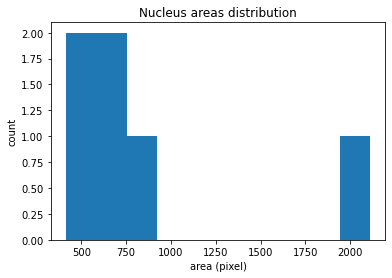

In [67]:
plt.hist(nuc_areas, bins=10)
plt.title("Nucleus areas distribution")
plt.xlabel("area (pixel)")
plt.ylabel("count");

### Intensité moyenne des noyaux

Pour mesurer l'intensité totale de chaque noyau, nous faisons la somme des valeurs d'intensité contenues dans l'*array numpy* du canal bleu (`fluocells_b`) associées aux pixels appartenant au noyau mesuré. Chaque intensité totale est ensuite divisée par l'aire du noyau correspondant pour obtenir des intensités moyennes.

In [68]:
# nuclei mean intensities

# create empty list to store mean intensities
nuc_intensities = []

# measure each nucleus intensity and append it to nuc_intensities
for i in range(nuclei_num):
    intensity = np.sum(nuclei_obj[i] * fluocells_b) / nuc_areas[i]
    nuc_intensities.append(intensity)
    print(f"nuc_{i + 1} mean intensity: {nuc_intensities[i]:.1f} per pixel")

nuc_1 mean intensity: 194.2 per pixel
nuc_2 mean intensity: 144.1 per pixel
nuc_3 mean intensity: 155.8 per pixel
nuc_4 mean intensity: 115.2 per pixel
nuc_5 mean intensity: 139.5 per pixel
nuc_6 mean intensity: 149.6 per pixel


La distribution de l'intensité moyenne des noyaux peut être visualisée sous forme d'histogramme.

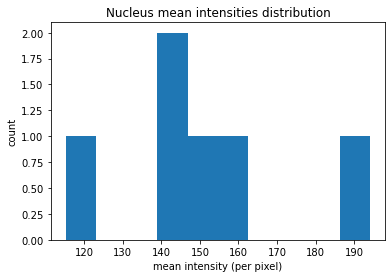

In [69]:
plt.hist(nuc_intensities, bins=10)
plt.title("Nucleus mean intensities distribution")
plt.xlabel("mean intensity (per pixel)")
plt.ylabel("count");

### Mesures avec les fonctions de *scikit-image*

Heureusement, ces mesures peuvent également être effectuées à l'aide du module *scikit-image*. La fonction `regionprops` du sous-module `measure` de *scikit-image* décrit un certain nombre de propriétés associées à chaque région étiquetée, dont l'aire et l'intensité moyenne. Ces propriétés sont accessibles *via* les attributs associés à l'objet renvoyé par la fonction (ici, `.area` pour l'aire, et `mean_intensity` pour l'intensité moyenne).

In [70]:
nuclei_props = skimage.measure.regionprops(nuclei_lab,
                                           intensity_image=fluocells_b)

nuclei_props_areas = np.zeros(nuclei_num)
nuclei_props_intensities = np.zeros(nuclei_num)
nuclei_props_perimeters = np.zeros(nuclei_num)

for i in range(len(nuclei_props)):
    nuclei_props_areas[i] = nuclei_props[i].area
    nuclei_props_intensities[i] = nuclei_props[i].mean_intensity
    nuclei_props_perimeters[i] = nuclei_props[i].perimeter

Nous pouvons représenter l'aire et l'intensité moyenne de chaque noyau sur le même graphique en traçant un nuage de points.

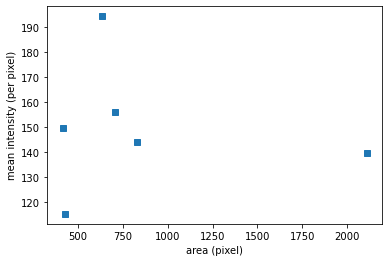

In [71]:
plt.plot(nuclei_props_areas, nuclei_props_intensities, "s")
plt.xlabel("area (pixel)")
plt.ylabel("mean intensity (per pixel)");

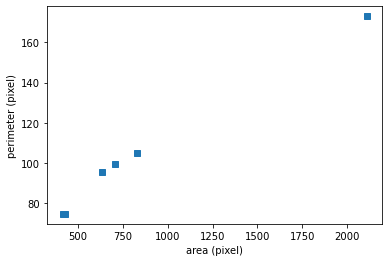

In [72]:
plt.plot(nuclei_props_areas, nuclei_props_perimeters, "s")
plt.xlabel("area (pixel)")
plt.ylabel("perimeter (pixel)");

**pour le contenu supplémentaire je propose d'effectuer d'autres mesures**\
typiquement regarder les autres propriétés renvoyées par la fonction

In [73]:
import plotly
import plotly.express
import plotly.graph_objects

import skimage.data
import skimage.filters
import skimage.measure
import skimage.morphology

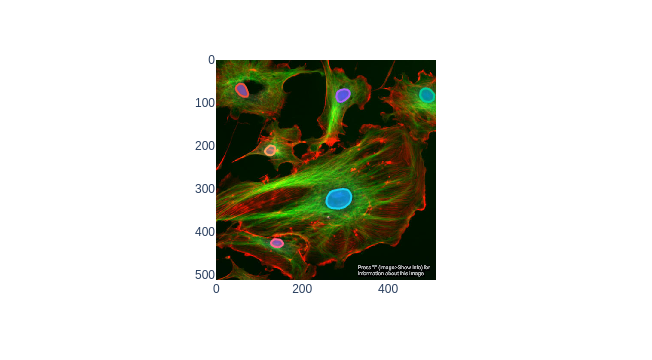

In [76]:
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology

img = data.coins()
# Binary image, post-process the binary mask and compute labels
threshold = filters.threshold_otsu(img)
mask = img > threshold
mask = morphology.remove_small_objects(mask, 50)
mask = morphology.remove_small_holes(mask, 50)
labels = measure.label(mask)

fig = px.imshow(fluocells, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter', 'mean_intensity']

# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for i in range(0, nuclei_num):
    label = nuclei_props[i].label
    contour = measure.find_contours(nuclei_lab == label, 0.5)[0] # also do this earlier in demo
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(nuclei_props[i], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

fig